# Project 1: Classify Images of Road Traffic Signs
Name: Muhammad Syahrul Hanis bin Mohamad Rasid <br> Student ID: s3781755

## Introduction

In this project, we will be using MLP to predict the shape of a sign in a 28 x 28 pixel image. We will then proceed to classify the signs according to type. The images are separated into files by shape, then separated again by sign type.

In [3]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.3.0'

## Reading and Setting up Data

We will read in the data and make some observations.

In [4]:
import zipfile
with zipfile.ZipFile('./trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [5]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./trafficsigns_dataset/**/**.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    sign_shape = filepath.split("\\")[-3]
    sign_type = filepath.split("\\")[-2]
    image_list.append((filepath, sign_shape, sign_type))
    
# Create a data frame
df = pd.DataFrame(data=image_list, columns=['image_path', 'sign_shape', 'sign_type'])
df.shape

(3699, 3)

There are a total of 3699 different images of signs in the dataset.

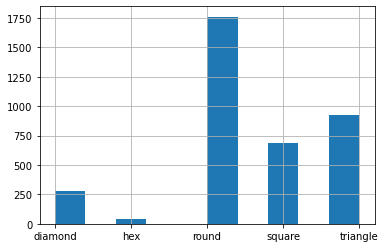

In [6]:
df.sign_shape.hist()
plt.show()

It seems that the dataset is biased around circular signs. The shape with the least amount of data is the hex shaped signs. Let us now plot some images for observation.

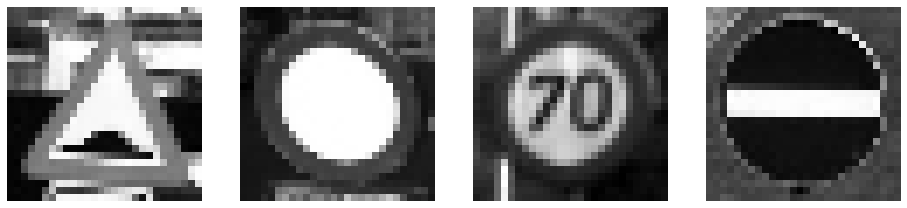

In [7]:
r_inx = np.random.choice(3699, 4)
rand_df = df.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_df):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

Let us now split our dataset into training, validation and test sets. We will be going for a 60/20/20 split.

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


## Model Development (MLP)

1. **Determine your goals**: Performance metric and target value. Problem dependent.

2. **Setup the experiment**: Setup the test/validation data, visualisers and debuggers needed to determine bottlenecks in performance (overfitting/under-fitting, feature importance).

3. **Default Baseline Model**: Identify the components of end-to-end pipeline including - Baseline Models, cost functions, optimisation.

4. **Make incremental changes**: Repeatedly make incremental changes such as gathering new data, adjusting hyper-parameters, or changing algorithms, based on specific findings from your instrumentation.

For our performance metric, we will be going forward with Accuracy as our dataset requires a multi-class classification. With a relatively small dataset, we will be aiming for a realistic 50% accuracy, since our model will be a simple neural network (MLP).

We have set up our dataset splits. Let us now create a performance learning curve as our diagnostic tool, to determine the efficiency of our model. This tool will assist us in determining if our model is under-fit, over-fit or well-fit and diagnose if our training and validation splits are representative of our overarching problem.

In [9]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Base Model (MLP)

Let us now set up a simple MLP with one hidden layer. We will set the dimension of the hidden layer to 256 and tune this hyper parameter as we develop our model.

In [10]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 5

### Set up the layers

We will use a simple Sequential API to build our model, as it is the simplest option. Our first layer will reformat and flatten our images and our hidden layer will create a score to predict the classification of said image.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               602368    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 603,653
Trainable params: 603,653
Non-trainable params: 0
_________________________________________________________________


In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Compile the model
For our loss function, we will be using categorical cross entropy because our output has multiple categories. We will also opt for a SGD optimizer and as previously mentioned, we will be using Accuracy as our performance metric.

In [14]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

## Train the model (MLP)
Now we will begin training our model in batches of 32 images because image recognition is a complicated process. We will use the keras ImageDataGenerator.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


We will now use Keras fit() to train the model.

In [16]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, batch_size = batch_size, verbose=0)

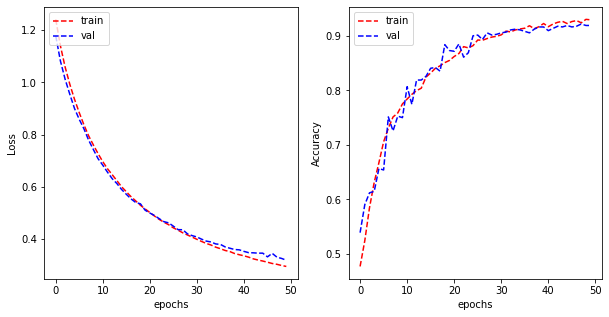

In [17]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

From the graphs generated, it can be seen that the model is slightly under fit for our problem. This is because both our training and validation losses both continue to decrease and have not reached a point of stability despite having a small generalisation gap between each other. Incremental changes are needed to increase the efficiency of the model.

## Incremental changes
We will proceed with adjusting the weight of the epoch to find a better fitting model.

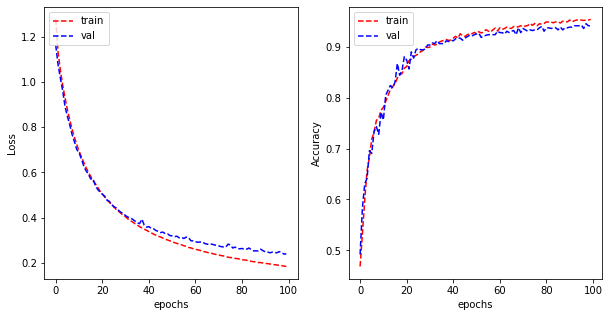

In [18]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])
model_1.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
history_1 = model_1.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_1.history['loss'], history_1.history['val_loss'], 
                    history_1.history['categorical_accuracy'], history_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

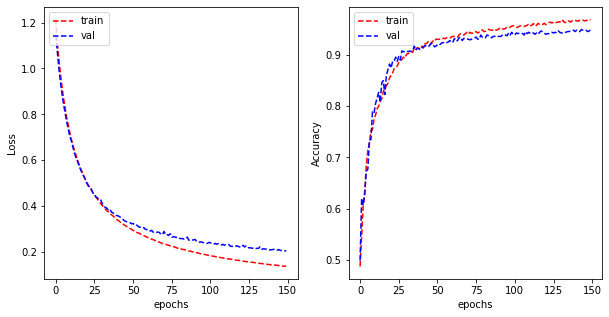

In [19]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])
model_2.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
history_2 = model_2.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

plot_learning_curve(history_2.history['loss'], history_2.history['val_loss'], 
                    history_2.history['categorical_accuracy'], history_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

From our observations a higher weighting for epochs results in a better fitting model. From the graph displayed above, we can deduce that this particular model is well fit because both training and validation loss have reached a point of stability in the graph.

## Test the model (MLP)
From our findings, we have concluded that the model that has been developed is well-fit, due to the incremental changes made to improve performance. Let us create a data generator to get our test data.

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 5 classes.


In [21]:
scores = model_2.evaluate(test_generator)
print("Accuracy: %.2f%%" % (scores[1]*100))

740/740 [==============================] - 1s 818us/step - loss: 0.2375 - categorical_accuracy: 0.9257
Accuracy: 92.57%


It appears that our model has a categorical accuracy of around 93%, which exceeds our goal of a 50% accuracy. Let us now plot our results.

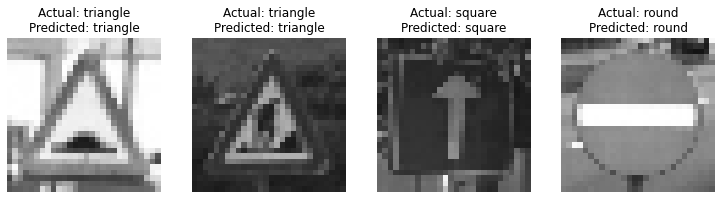

In [22]:
label_names = {'diamond' : 0, 'hex' : 1, 'round' : 2, 'square' : 3, 'triangle' : 4}

d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_2.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("Actual: {}\nPredicted: {}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

## Model Development (CNN)
We will now be creating a model to classify our signs according to their sign type. We will be using a different type of model compared to our previous model so that we will be able to compare and analyse the efficiency of a simple MLP against a Convolutional Neural Network.

We will be using the same dataset and data split that we have already processed beforehand. We will also be reusing the same performance metric, Accuracy, along with the same performance learning curve as our diagnostic tool. Since we are using a deep CNN model, we will be aiming for a final accuracy of at least 70%. Let us first observe the distribution of the types of signs.

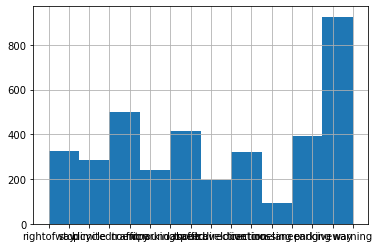

In [23]:
df.sign_type.hist()
plt.show()

It appears that our dataset contains a large amount of warning signs with a relatively small amount of stop signs.

## Base Model (CNN)


We will be implementing the LeNet architecture for our base model as it is relatively small and simple in terms of implementation. Let us set up the data for the model.

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

type_train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

type_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


## Setting up the base model
We will set up our base model with the leNet architecture with some modifications.

In [25]:
reg_lambda = 0.001
OUTPUT_CLASSES = 16

model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [26]:
model_leNet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)         

## Training the model
Let us now train the model and observe our results.

In [27]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [28]:
history_type = model_leNet.fit(type_train_generator, 
                                    validation_data = type_validation_generator, 
                                    epochs=10, verbose=0)

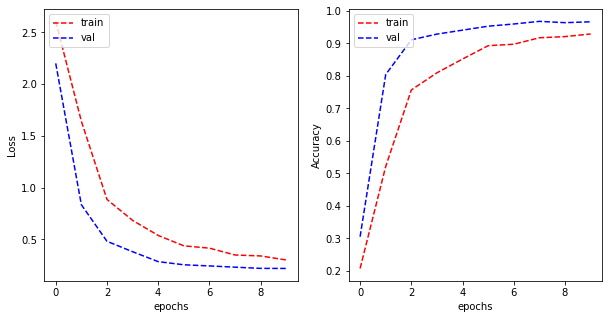

In [29]:
plot_learning_curve(history_type.history['loss'], history_type.history['val_loss'], 
                    history_type.history['categorical_accuracy'], history_type.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

It seems that our model is slightly under fit as the training and validation losses are not yet at a point of stability. We will make some incremental changes to this model.

## Incremental changes
Let us adjust our dropout percentage and reduce it. In doing so, we will effectively be reducing the subset of nodes that we ignore in our model, and ultimately result in a better fitting model. We will also increase our epoch weight to 15.

We will first reduce the percentage to a 30% dropout rate.

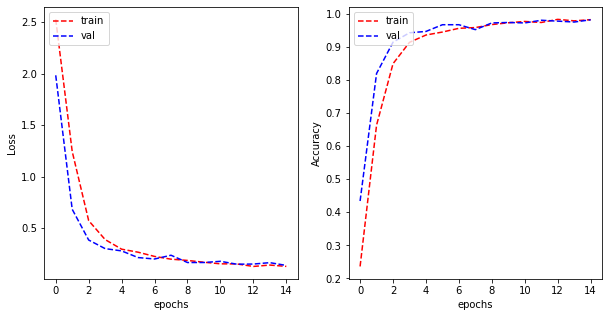

In [30]:
reg_lambda = 0.001
OUTPUT_CLASSES = 16

model_leNet_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
 
model_leNet_1.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_type_1 = model_leNet_1.fit(type_train_generator, 
                                    validation_data = type_validation_generator, 
                                    epochs=15, verbose=0)

plot_learning_curve(history_type_1.history['loss'], history_type_1.history['val_loss'], 
                    history_type_1.history['categorical_accuracy'], history_type_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

We will now reduce the dropout percentage to 10%.

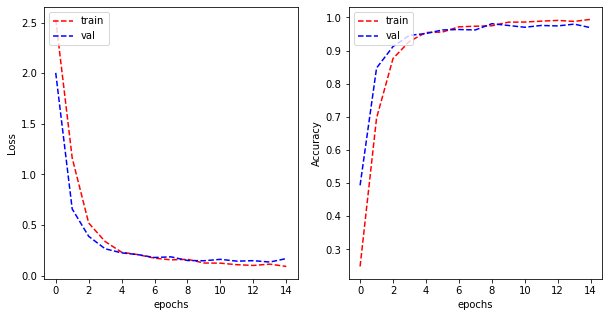

In [31]:
reg_lambda = 0.001
OUTPUT_CLASSES = 16

model_leNet_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
 
model_leNet_2.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_type_2 = model_leNet_2.fit(type_train_generator, 
                                    validation_data = type_validation_generator, 
                                    epochs=15, verbose=0)

plot_learning_curve(history_type_2.history['loss'], history_type_2.history['val_loss'], 
                    history_type_2.history['categorical_accuracy'], history_type_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

We will now remove any dropout in our model.

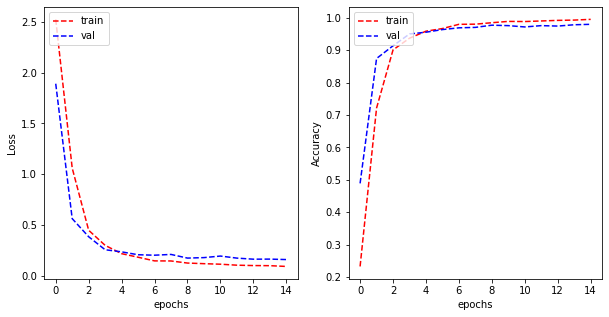

In [32]:
reg_lambda = 0.001
OUTPUT_CLASSES = 16

model_leNet_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
 
model_leNet_3.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_type_3 = model_leNet_3.fit(type_train_generator, 
                                    validation_data = type_validation_generator, 
                                    epochs=15, verbose=0)

plot_learning_curve(history_type_3.history['loss'], history_type_3.history['val_loss'], 
                    history_type_3.history['categorical_accuracy'], history_type_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

From our observations, it can be seen that the model with 30% dropout performs the best as the training and validation loss has reached a point of stability, resulting in the best fit out of all the models.

## Testing the model
We will now test our model since we have concluded that our model is well fit.

In [33]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

type_test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 16 classes.


In [34]:
scores = model_leNet_1.evaluate(type_test_generator)
print("Accuracy: %.2f%%" % (scores[1]*100))

740/740 [==============================] - 1s 869us/step - loss: 0.1409 - categorical_accuracy: 0.9797
Accuracy: 97.97%


It appears that model 1 has the highest accuracy between all our models. Despite this, all our models have exceeded the expected accuracy percentage of 70%. Let us now plot some of our predictions.

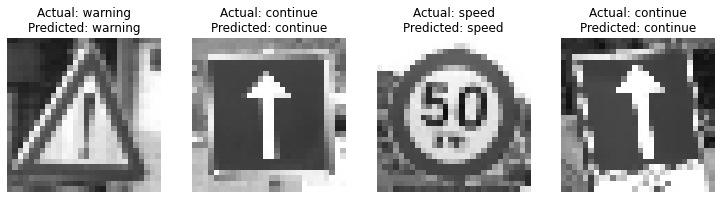

In [35]:
label_names = ['rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry',
       'noparking', 'roundabout', 'speed', 'trafficdirective',
       'traveldirection', 'continue', 'crossing', 'laneend', 'parking',
       'giveway', 'warning']
label_names.sort()
d_inv = {v: k for v, k in enumerate(label_names)}
plt.figure(figsize=(16,4))
batches = 0
for x,y in type_test_generator:
        batches = batches + 1
        y_hat = model_leNet_1.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("Actual: {}\nPredicted: {}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# Ultimate Judgement
From the findings, it is evident that the Convolutional Neural Network model outperforms the Multiple Layer Perceptron, with accuracy scores far greater than that of the MLP model.

The MLP model has some drawbacks regarding image classification problems. The complexity of the model is dependent on the input size of the problem, which may result in a longer time to process results and requires a lot of data to train the model. If a large number of layers is needed for the model, this may also cause an issue known as vanishing gradient where the training signal at the initial layers are low causing the model to not be able to learn things effectively. Overall, the MLP model is not the best model for image classification because it does not scale well with the complexity of the task.

The CNN model however, is quite effective at image classification since it mimics the image processing pipeline. It gets rid of redundant information in an image by only scanning small parts of the whole image through convolution. It's complexity is also independent of the input size as the number of parameters is dependent on the number of convolution layers in the model. CNN also transforms the image into a subset of important features to effectively classify each image.

Overall, for my ultimate judgement, the best model for efficiently and effectively classifying an image is the convolutional neural network model.

# Independent Evaluation
We will now evaluate our ultimate judgement by using data collected from outside our training scope. To test this, we will read in 10 copyright free images that were outsourced, mimicking a real world situation where the model is unable to be retrained or have its hyperparameters adjusted. We will test the performance of both our MLP and CNN models and evaluate accordingly.

Let us first read and set up our data.

In [36]:
image_list_eval = []
for filepath in glob.glob('./independent_eval/**/**.png', recursive=True):
    filename = filepath.split("./")[1]
    sign_shape = filepath.split("\\")[-2]
    sign_type = filepath.split("\\")[-1][:-4]
    image_list_eval.append((filepath, sign_shape, sign_type))
    
# Create a data frame
df_eval = pd.DataFrame(data=image_list_eval, columns=['image_path', 'sign_shape', 'sign_type'])
df_eval.shape

(10, 3)

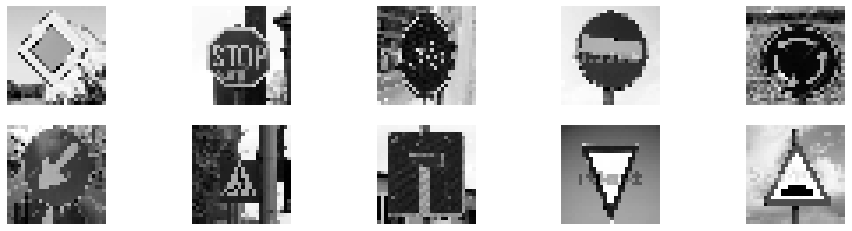

In [37]:
import cv2
plt.figure(figsize=(16,4))
count = 0
for i in df_eval['image_path']:
    count += 1 
    img = cv2.imread(i)
    img = cv2.resize(img, (28,28))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(2,5, count)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    
plt.show()

## MLP evaluation

In [38]:
eval_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

eval_generator = eval_datagen.flow_from_dataframe(
        dataframe=df_eval,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 10 validated image filenames belonging to 5 classes.


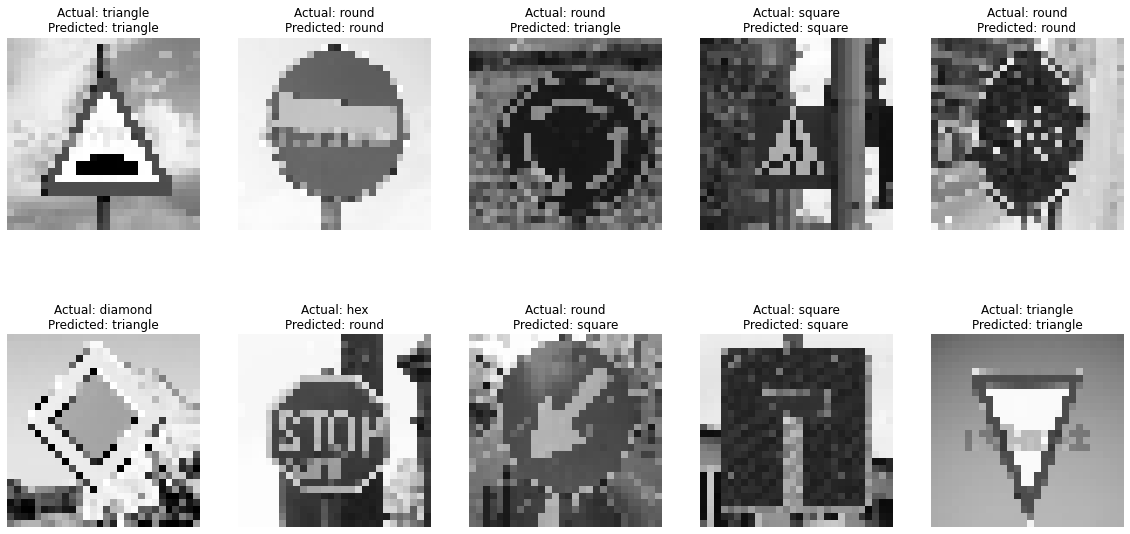

In [39]:
label_names = {'diamond' : 0, 'hex' : 1, 'round' : 2, 'square' : 3, 'triangle' : 4}

d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in eval_generator:
        batches = batches + 1
        y_hat = model_2.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches <=10:
            plt.subplot(2,5,batches)
            plt.imshow(x)
            plt.title("Actual: {}\nPredicted: {}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

## CNN Evaluation

In [40]:
type_eval_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

type_eval_generator = eval_datagen.flow_from_dataframe(
        dataframe=df_eval,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 10 validated image filenames belonging to 10 classes.


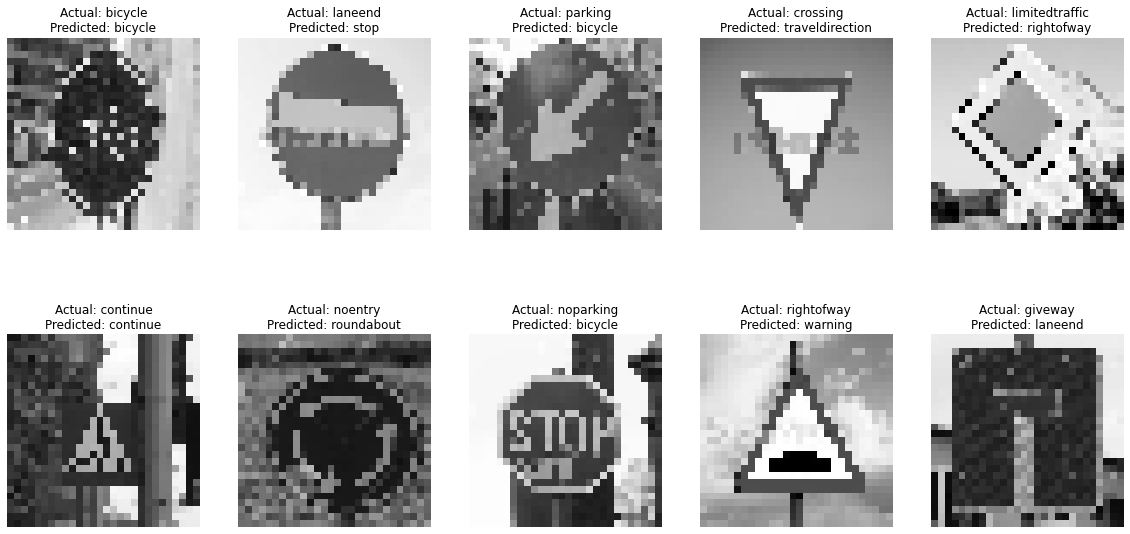

In [41]:
label_names = ['rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry',
       'noparking', 'roundabout', 'speed', 'trafficdirective',
       'traveldirection', 'continue', 'crossing', 'laneend', 'parking',
       'giveway', 'warning']
label_names.sort()
d_inv = {v: k for v, k in enumerate(label_names)}
plt.figure(figsize=(20,10))
batches = 0
for x,y in type_eval_generator:
        batches = batches + 1
        y_hat = model_leNet_1.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches <= 10:
            plt.subplot(2,5,batches)
            plt.imshow(x)
            plt.title("Actual: {}\nPredicted: {}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

 # Approach, Critical Analysis & Report

## Algorithm selection
When first selecting an algorithm for this problem, I have considered some other options such as logistic regression and decision trees. The issue with these algorithms is that they require proper features to be trained upon, since these algorithms do not allow the raw image to be fed into the model. As a result, the classification process would be sub-optimal and the accuracy of the models would be low.

In a pursuit for a better model for image classification, I have opted for MLP and CNN because these neural networks are widely used for image classifications. These neural networks, are able to take an image input and assign weights and biases to various features within the image. These models are built for image classification, which reduces the amount of pre-processing required when compared to other algorithms, and overall, makes these algorithms a much better option than others.

## Evaluation of models
The models that I have developed did not meet expectations, considering their accuracies were relatively high. I believe, the results were what was observed because of the quality of the images that were being predicted. For example, the MLP model for predicting the shape of the sign had a much higher success rate because the shapes were still well defined within the resized images. As a result, the model was still able to predict properly, but not as effective as it was during the training phase. For the classification of sign type using the CNN model, the results were also affected by the quality of the images. These images have signs with visuals that were barely distinguishable and as a result, the model could not effectively classify each image.

Another reason the models did not perform as well is due to the fact that the images outsourced, had some slight differences within the photos. These may include factors such as the centering of the sign, the visual background noise present and may even stretch to the watermarks that were present in the images. These factors were not considered when training the model, and as such, the results reflect that.

Overall, if these factors were considered when training the models, they would perform significantly better. An essential change would be to find images that were the same size as the ones that the model is being trained on, but due to the lack of available images on the internet, which were copyright free, these constraints were not met. Regardless, these models developed did not perform well in a real life situation.

## References
* Khalid, Irfan Alghani. “Multilayer Perceptron for Image Classification.” Medium, Towards Data Science, 11 May 2021, https://towardsdatascience.com/multilayer-perceptron-for-image-classification-5c1f25738935. 
* Mishra, Prafful. “Why Are Convolutional Neural Networks Good for Image Classification?” Medium, DataDrivenInvestor, 27 May 2019, https://medium.datadriveninvestor.com/why-are-convolutional-neural-networks-good-for-image-classification-146ec6e865e8. 
* https://www.dreamstime.com/traffic-sign-dead-end-street-germany-traffic-sign-dead-end-street-germany-square-rectangular-sign-image221858146
* https://www.ageco.co.uk/viewpoint/insurance/10-driving-rules-in-europe/
* https://www.dreamstime.com/stock-photo-roundabout-road-bruges-belgium-sign-modern-motorway-expresweg-vicinity-image84530488
* https://www.canstockphoto.com/no-entry-sign-75948335.html
* https://torange.biz/controlled-pedestrian-crossing-14676
* https://www.shutterstock.com/image-photo/road-signs-give-way-sign-on-1267462420
* https://www.dreamstime.com/traffic-sign-cyclists-brussels-belgium-image228780635
* https://www.123rf.com/photo_136645575_regulatory-signs-proceed-in-direction-indicated-by-left-arrow-traffic-sign.html?vti=n44a3yocx6v2k4gknc-1-128
